<a href="https://colab.research.google.com/github/Moe-phantom/leetcoding/blob/main/tabPNF_model_features.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121 -q
!pip install tabpfn[gpu] --upgrade -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 173.7/173.7 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.3/137.3 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.7/64.7 kB 4.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests==2.32.4, but you have requests 2.32.5 which is incompatible.


In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, balanced_accuracy_score
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance  # ✅ ADD THIS LINE
import warnings
import pickle
import os

In [13]:

# ==============================
# Import after installation
# ==============================

warnings.filterwarnings('ignore')

# 🔥 CRITICAL: Import torch AFTER installation to check CUDA
import torch
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")


PyTorch version: 2.8.0+cu126
CUDA available: True
CUDA device: Tesla T4


In [14]:
# ==============================
# Configuration
# ==============================
RANDOM_STATE = 42
TEST_SIZE = 0.2
MAX_TRAIN_SIZE = 1024  # TabPFN limit
TARGET_CP_SIZE = 3678
# ==============================
# Load Data
# ==============================

csv_path = '/content/TOI_2025.09.28_05.51.22.csv'  # UPDATE THIS PATH
if not os.path.exists(csv_path):
    raise FileNotFoundError(f"CSV file not found at {csv_path}. Please update the path.")

df = pd.read_csv(csv_path, comment='#')
print(f"Dataset shape: {df.shape}")


Dataset shape: (7699, 27)


In [28]:
# ==============================
# Target & Features
# ==============================
target_col = 'tfopwg_disp'

# Define semantic groups
PLANET_CLASSES = ['PC', 'CP', 'KP']      # Confirmed + Known Planets
FALSE_POS_CLASSES = ['FA', 'FP']   # False Alarms + False Positives
DROP_CLASSES = ['APC']             # Ambiguous — drop entirely

df_clean = df[~df[target_col].isin(DROP_CLASSES)].copy()
print(f"After dropping APC: {df_clean.shape}")

# Separate CP for downsampling
cp_mask = df_clean[target_col] == 'PC'
cp_data = df_clean[cp_mask]
non_cp_data = df_clean[~cp_mask]



After dropping APC: (7238, 27)


In [29]:
if len(cp_data) > TARGET_CP_SIZE:
    cp_data = cp_data.sample(n=TARGET_CP_SIZE, random_state=RANDOM_STATE)
    print(f"Downsampled CP from {len(df_clean[cp_mask])} to {TARGET_CP_SIZE}")

# Recombine
df_balanced = pd.concat([cp_data, non_cp_data], ignore_index=True)

Downsampled CP from 4678 to 3678


In [30]:
# Recombine
df_balanced = pd.concat([cp_data, non_cp_data], ignore_index=True)

# Create binary target
def map_to_binary(label):
    if label in PLANET_CLASSES:
        return 'Planet'
    elif label in FALSE_POS_CLASSES:
        return 'False Positive'
    else:
        return None  # Should not happen
df_balanced['binary_target'] = df_balanced[target_col].map(map_to_binary)
df_balanced = df_balanced.dropna(subset=['binary_target'])

print("\nBalanced class distribution:")
print(df_balanced['binary_target'].value_counts())


Balanced class distribution:
binary_target
Planet            4944
False Positive    1294
Name: count, dtype: int64


In [42]:
def engineer_physics_features(df):
    df = df.copy()
    created = []

    # 1. Transit SNR proxy (using pl_trandep and st_tmag)
    if 'pl_trandep' in df.columns and 'st_tmag' in df.columns:
        df['transit_snr'] = df['pl_trandep'] * (10 ** (-df['st_tmag'] / 5))
        created.append('transit_snr')

    # 2. Duration ratio → USE pl_trandurh (already in hours!)
    if 'pl_trandurh' in df.columns and 'pl_orbper' in df.columns:
        # pl_trandurh = duration in hours
        # pl_orbper = period in days → convert to hours: *24
        df['duration_ratio'] = df['pl_trandurh'] / (df['pl_orbper'] * 24 + 1e-6)
        created.append('duration_ratio')

    # 3. Depth residual → COMPUTE pl_ratror from pl_rade and st_rad
    if all(col in df.columns for col in ['pl_trandep', 'pl_rade', 'st_rad']):
        # Compute planet-star radius ratio
        R_earth_to_R_sun = 0.009155  # Constant
        df['pl_ratror'] = (df['pl_rade'] * R_earth_to_R_sun) / (df['st_rad'] + 1e-6)
        # Now compute residual
        observed_depth = df['pl_trandep'] / 1e6  # ppm → fraction
        expected_depth = df['pl_ratror'] ** 2
        df['depth_residual'] = np.abs(observed_depth - expected_depth)
        created.extend(['pl_ratror', 'depth_residual'])

    # 4. Log transforms
    log_cols = ['pl_orbper', 'pl_rade', 'pl_insol']
    for col in log_cols:
        if col in df.columns:
            df[f'{col}_log'] = np.log10(df[col] + 1e-6)
            created.append(f'{col}_log')

    print(f"✅ Created features: {created}")
    return df

In [43]:
df_engineered = engineer_physics_features(df_balanced)

# 🔎 DEBUG: Print ALL columns in df_engineered
print("\n🔍 ALL columns after feature engineering:")
print(df_engineered.columns.tolist())

# 🔎 DEBUG: Check if key engineered features exist
for feat in ['transit_snr', 'duration_ratio', 'depth_residual', 'pl_rade_log']:
    if feat in df_engineered.columns:
        print(f"✅ {feat} is present")
    else:
        print(f"❌ {feat} is MISSING")

✅ Created features: ['transit_snr', 'duration_ratio', 'pl_ratror', 'depth_residual', 'pl_orbper_log', 'pl_rade_log', 'pl_insol_log']

🔍 ALL columns after feature engineering:
['rowid', 'toi', 'toipfx', 'tid', 'ctoi_alias', 'pl_pnum', 'tfopwg_disp', 'rastr', 'ra', 'decstr', 'dec', 'st_pmra', 'st_pmdec', 'pl_tranmid', 'pl_orbper', 'pl_trandurh', 'pl_trandep', 'pl_rade', 'pl_insol', 'pl_eqt', 'st_tmag', 'st_dist', 'st_teff', 'st_logg', 'st_rad', 'toi_created', 'rowupdate', 'binary_target', 'transit_snr', 'duration_ratio', 'pl_ratror', 'depth_residual', 'pl_orbper_log', 'pl_rade_log', 'pl_insol_log']
✅ transit_snr is present
✅ duration_ratio is present
✅ depth_residual is present
✅ pl_rade_log is present


In [44]:
print("🔍 Checking for required columns for feature engineering:")
required_cols = ['pl_trandep', 'st_tmag', 'pl_trandur', 'pl_orbper', 'pl_ratror', 'pl_rade']
for col in required_cols:
    status = "✅ FOUND" if col in df.columns else "❌ MISSING"
    print(f"  {col}: {status}")

🔍 Checking for required columns for feature engineering:
  pl_trandep: ✅ FOUND
  st_tmag: ✅ FOUND
  pl_trandur: ❌ MISSING
  pl_orbper: ✅ FOUND
  pl_ratror: ❌ MISSING
  pl_rade: ✅ FOUND


In [46]:
# ==============================
# STEP 3: FEATURE SELECTION & PREP
# ==============================
base_features = [
    'pl_orbper', 'pl_rade', 'pl_trandep', 'pl_trandur', 'st_tmag',
    'st_rad', 'st_teff', 'st_logg', 'pl_insol', 'pl_eqt',
    'pl_ratdor', 'pl_ratror'
]

# Add engineered features
engineered_cols = ['transit_snr', 'duration_ratio', 'depth_residual',
                   'pl_orbper_log', 'pl_rade_log', 'pl_insol_log']

all_features = base_features + engineered_cols
available_features = [c for c in all_features if c in df_engineered.columns]

# Exclude problematic cols
exclude = ['ra', 'dec', 'tic', 'toi', 'comments', 'flag', 'url', 'date','toipfx','ctoi_alias', 'pl_pnum']
final_features = [c for c in available_features
                  if not any(p in c.lower() for p in exclude)]

print(f"\nUsing {len(final_features)} features: {final_features}")



Using 9 features: ['pl_orbper', 'st_tmag', 'st_teff', 'st_logg', 'pl_insol', 'pl_eqt', 'depth_residual', 'pl_orbper_log', 'pl_insol_log']


In [33]:
# After feature engineering and before imputation
X = df_engineered[final_features].copy()
y = df_engineered['binary_target'].copy()

# Convert X to numeric
for col in X.columns:
    X[col] = pd.to_numeric(X[col], errors='coerce')

# 💡 CRITICAL: Reset index of BOTH X and y to ensure alignment
X = X.reset_index(drop=True)
y = y.reset_index(drop=True)

# Now impute
imputer = SimpleImputer(strategy='median')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

# Now mask works!
mask = ~y.isnull()
X_final = X_imputed[mask]
y_final = y[mask]

In [34]:
# ==============================
# TRAINING
# ==============================
# ✅ STEP 1: Encode the target FIRST
from tabpfn import TabPFNClassifier
le = LabelEncoder()
y_encoded = le.fit_transform(y_final)  # Now y_encoded exists!
class_names = le.classes_

X_train, X_test, y_train, y_test = train_test_split(
    X_final, y_encoded, test_size=TEST_SIZE,
    random_state=RANDOM_STATE, stratify=y_encoded
)

# Subsample if needed
if len(X_train) > MAX_TRAIN_SIZE:
    idx = np.random.choice(len(X_train), MAX_TRAIN_SIZE, replace=False)
    X_train_sub, y_train_sub = X_train.iloc[idx], y_train[idx]
else:
    X_train_sub, y_train_sub = X_train, y_train

# Train with GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
tabpfn = TabPFNClassifier(device=device)  # ✅ No N_ensemble_configurations!
print("Training physics-informed TabPFN...")
tabpfn.fit(X_train_sub.values, y_train_sub)


Training physics-informed TabPFN...


TabPFNClassifier(device='cuda')

In [35]:
# Predict
y_pred = tabpfn.predict(X_test.values)

# Evaluate
acc = accuracy_score(y_test, y_pred)
bal_acc = balanced_accuracy_score(y_test, y_pred)

print(f"\n✅ Final Results:")
print(f"Accuracy: {acc:.3f}")
print(f"Balanced Accuracy: {bal_acc:.3f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=class_names))



✅ Final Results:
Accuracy: 0.827
Balanced Accuracy: 0.616

Classification Report:
                precision    recall  f1-score   support

False Positive       0.74      0.25      0.38       259
        Planet       0.83      0.98      0.90       989

      accuracy                           0.83      1248
     macro avg       0.79      0.62      0.64      1248
  weighted avg       0.81      0.83      0.79      1248



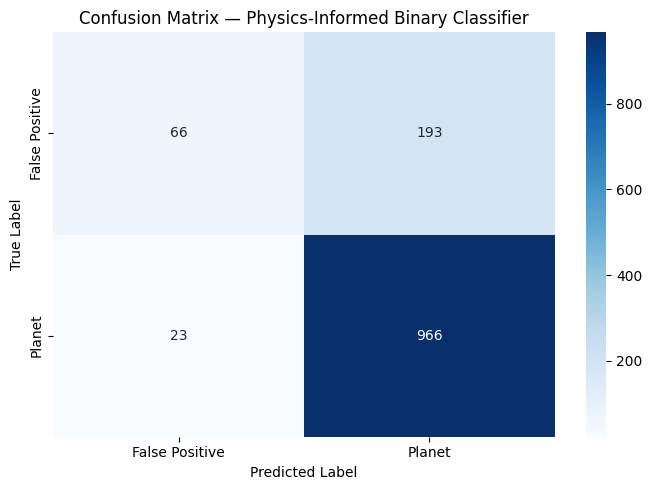

In [36]:
# Confusion Matrix
plt.figure(figsize=(7, 5))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix — Physics-Informed Binary Classifier')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()


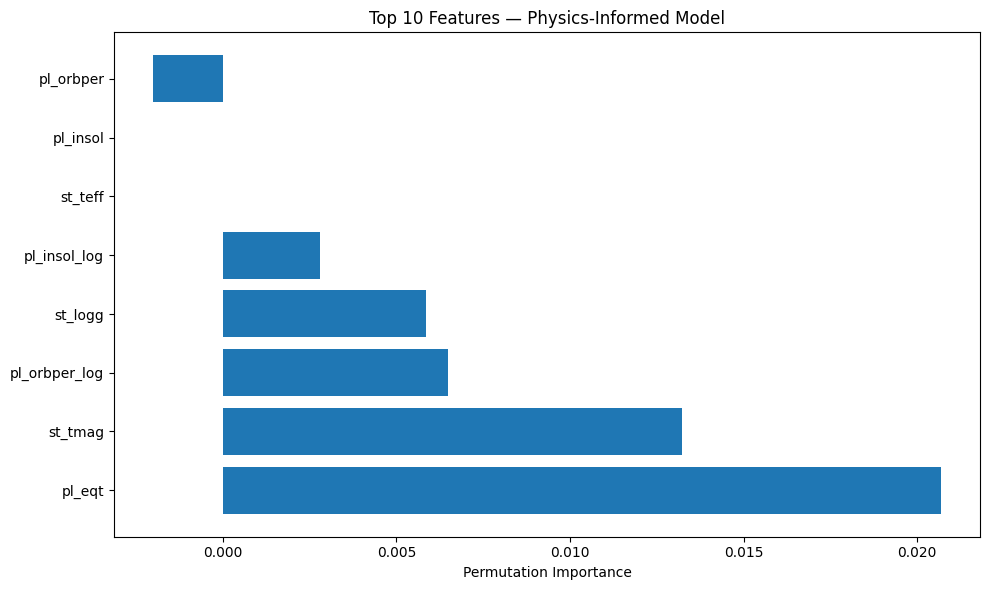

In [37]:
# Feature Importance
perm_imp = permutation_importance(tabpfn, X_test.values, y_test,
                                  n_repeats=10, random_state=RANDOM_STATE)
feat_imp = pd.DataFrame({
    'feature': X_test.columns,
    'importance': perm_imp.importances_mean
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
top10 = feat_imp.head(10)
plt.barh(range(len(top10)), top10['importance'])
plt.yticks(range(len(top10)), top10['feature'])
plt.xlabel('Permutation Importance')
plt.title('Top 10 Features — Physics-Informed Model')
plt.tight_layout()
plt.show()



In [27]:
# Save
with open('tess_planet_classifier_1st.pkl', 'wb') as f:
    pickle.dump({
        'model': tabpfn,
        'features': list(X_final.columns),
        'imputer': imputer,
        'label_encoder': le,
        'balanced_accuracy': bal_acc
    }, f)

print("\n🎉 Model saved! Ready for deployment.")


🎉 Model saved! Ready for deployment.


In [ ]:
if target_col not in df.columns:
    possible = [c for c in df.columns if 'disp' in c.lower() or 'class' in c.lower()]
    raise ValueError(f"Target '{target_col}' not found. Candidates: {possible}")

# Feature list
feature_cols = [
    'pl_orbper', 'pl_rade', 'pl_trandep', 'pl_trandur', 'st_tmag',
    'st_rad', 'st_teff', 'st_logg', 'pl_insol', 'pl_eqt',
    'pl_ratdor', 'pl_ratror'
]
snr_cols = [col for col in df.columns if 'snr' in col.lower()]
feature_cols.extend(snr_cols)

# Exclude unwanted
exclude_patterns = ['ra', 'dec', 'tic', 'toi', 'comments', 'flag', 'url', 'date']
available_features = [c for c in feature_cols if c in df.columns]
features_to_use = [c for c in available_features
                   if not any(p in c.lower() for p in exclude_patterns)]

print(f"Using {len(features_to_use)} features: {features_to_use}")



In [5]:
X = df[features_to_use].copy()
y = df[target_col].copy()

# Convert to numeric
for col in X.columns:
    X[col] = pd.to_numeric(X[col], errors='coerce')

# Handle missing in pl_orbper
if 'pl_orbper' in X.columns:
    X['pl_orbper'].fillna(999, inplace=True)

# Impute rest
imputer = SimpleImputer(strategy='median')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

# Remove missing targets
mask = ~y.isnull()
X_imputed = X_imputed[mask]
y = y[mask]
print(f"Final dataset shape: {X_imputed.shape}")

# Encode target
le = LabelEncoder()
y_encoded = le.fit_transform(y)
class_names = le.classes_
print(f"Classes: {class_names}")

# =

Final dataset shape: (7699, 6)
Classes: ['APC' 'CP' 'FA' 'FP' 'KP' 'PC']


In [6]:
# ==============================
# GPU Setup for TabPFN
# ==============================
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"\nUsing device: {device}")

# Import TabPFN AFTER torch is ready
from tabpfn import TabPFNClassifier


Using device: cuda


In [10]:
print("\n" + "="*50)
print("STRATEGY 1: 6-CLASS CLASSIFICATION")
print("="*50)

X_train, X_test, y_train, y_test = train_test_split(
    X_imputed, y_encoded, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y_encoded
)

# Subsample if needed
if len(X_train) > MAX_TRAIN_SIZE:
    idx = np.random.choice(len(X_train), MAX_TRAIN_SIZE, replace=False)
    X_train_sub, y_train_sub = X_train.iloc[idx], y_train[idx]
else:
    X_train_sub, y_train_sub = X_train, y_train

# Train TabPFN with GPU
tabpfn = TabPFNClassifier(
    device=device)
print("Training TabPFN (6-class)...")
tabpfn.fit(X_train_sub.values, y_train_sub)  # Use .values for safety

y_pred = tabpfn.predict(X_test.values)
y_proba = tabpfn.predict_proba(X_test.values)

accuracy = accuracy_score(y_test, y_pred)
balanced_acc = balanced_accuracy_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.3f}")
print(f"Balanced Accuracy: {balanced_acc:.3f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=class_names, digits=3))



STRATEGY 1: 6-CLASS CLASSIFICATION
Training TabPFN (6-class)...


tabpfn-v2-classifier-finetuned-zk73skhh.(…):   0%|          | 0.00/29.0M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/37.0 [00:00<?, ?B/s]

Accuracy: 0.649
Balanced Accuracy: 0.249

Classification Report:
              precision    recall  f1-score   support

         APC      0.000     0.000     0.000        92
          CP      0.581     0.182     0.278       137
          FA      0.000     0.000     0.000        19
          FP      0.544     0.364     0.436       239
          KP      0.000     0.000     0.000       117
          PC      0.664     0.949     0.781       936

    accuracy                          0.649      1540
   macro avg      0.298     0.249     0.249      1540
weighted avg      0.540     0.649     0.567      1540



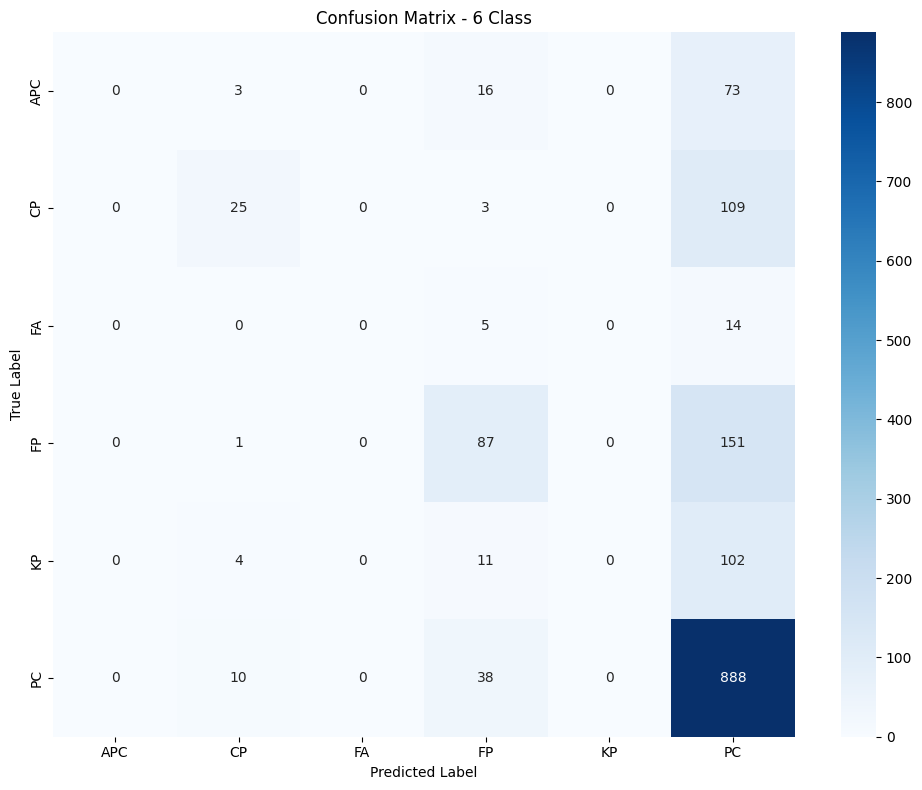

In [11]:
# Confusion Matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix - 6 Class')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()


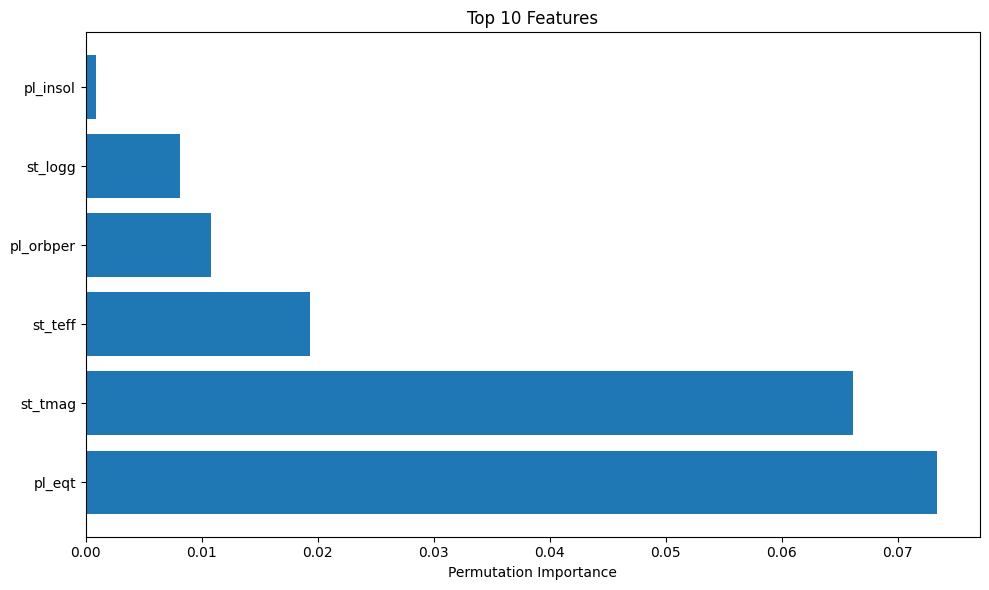

In [12]:
# Feature Importance
from sklearn.inspection import permutation_importance
perm_imp = permutation_importance(tabpfn, X_test.values, y_test, n_repeats=10, random_state=RANDOM_STATE)
feat_imp_df = pd.DataFrame({
    'feature': X_test.columns,
    'importance': perm_imp.importances_mean,
    'std': perm_imp.importances_std
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
top10 = feat_imp_df.head(10)
plt.barh(range(len(top10)), top10['importance'])
plt.yticks(range(len(top10)), top10['feature'])
plt.xlabel('Permutation Importance')
plt.title('Top 10 Features')
plt.tight_layout()
plt.show()


In [14]:
# ==============================
# Strategy 2: Binary Classification
# ==============================
print("\n" + "="*50)
print("STRATEGY 2: BINARY CLASSIFICATION")
print("="*50)

planet_classes = ['PC', 'APC', 'CP', 'KP']
y_binary = y.isin(planet_classes).astype(int)

X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(
    X_imputed, y_binary, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y_binary
)

if len(X_train_b) > MAX_TRAIN_SIZE:
    idx = np.random.choice(len(X_train_b), MAX_TRAIN_SIZE, replace=False)
    X_train_b_sub, y_train_b_sub = X_train_b.iloc[idx], y_train_b.iloc[idx]
else:
    X_train_b_sub, y_train_b_sub = X_train_b, y_train_b

tabpfn_binary = TabPFNClassifier(device=device)
print("Training binary TabPFN...")
tabpfn_binary.fit(X_train_b_sub.values, y_train_b_sub)

y_pred_b = tabpfn_binary.predict(X_test_b.values)
accuracy_b = accuracy_score(y_test_b, y_pred_b)
balanced_acc_b = balanced_accuracy_score(y_test_b, y_pred_b)

print(f"Binary Accuracy: {accuracy_b:.3f}")
print(f"Balanced Accuracy: {balanced_acc_b:.3f}")



STRATEGY 2: BINARY CLASSIFICATION
Training binary TabPFN...
Binary Accuracy: 0.849
Balanced Accuracy: 0.609


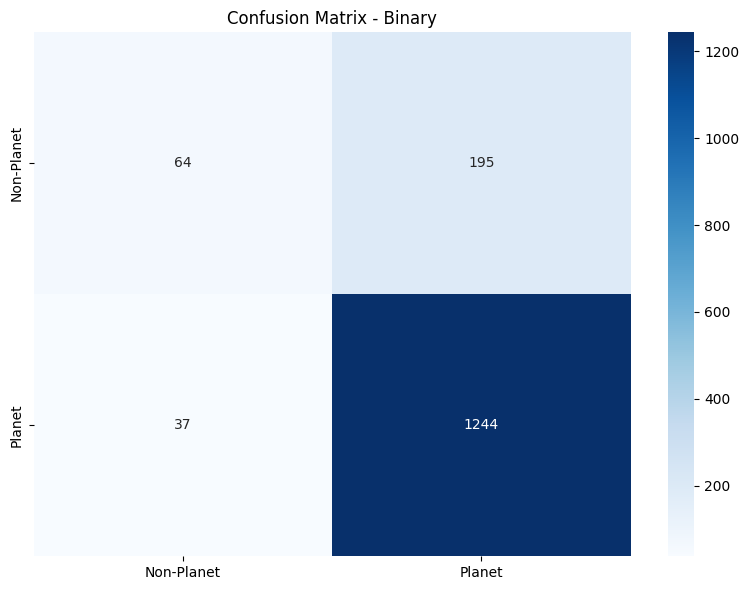

In [15]:
# Binary Confusion Matrix
plt.figure(figsize=(8, 6))
cm_b = confusion_matrix(y_test_b, y_pred_b)
sns.heatmap(cm_b, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Planet', 'Planet'], yticklabels=['Non-Planet', 'Planet'])
plt.title('Confusion Matrix - Binary')
plt.tight_layout()
plt.show()


In [16]:
# ==============================
# Save Model
# ==============================
model_artifact = {
    'model': tabpfn_binary,
    'feature_columns': list(X_imputed.columns),
    'imputer': imputer,
    'is_binary': True,
    'accuracy': accuracy_b,
    'balanced_accuracy': balanced_acc_b
}

with open('tabpfn_binary_model.pkl', 'wb') as f:
    pickle.dump(model_artifact, f)

print("\n✅ Model saved to 'tabpfn_binary_model.pkl'")



✅ Model saved to 'tabpfn_binary_model.pkl'


In [17]:
# ==============================
# Final Summary
# ==============================
summary = f"""
TESS TOI Classification Results:
- Device: {device}
- Samples: {len(X_imputed)}
- Features: {len(features_to_use)}
- Planet fraction: {y_binary.mean():.1%}
- Binary Accuracy: {accuracy_b:.1%}
- Top feature: {feat_imp_df.iloc[0]['feature']}
"""
print("\n" + "="*50)
print("SUMMARY")
print("="*50)
print(summary)


SUMMARY

TESS TOI Classification Results:
- Device: cuda
- Samples: 7699
- Features: 6
- Planet fraction: 83.2%
- Binary Accuracy: 84.9%
- Top feature: pl_eqt

